In [ ]:
#%cd Mask_RCNN/
#!pip install -r requirements.txt 
#!python3 setup.py install

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import tensorflow as tf

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import datetime
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
import h5py
import keras
import imgaug
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

%load_ext tensorboard


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


# Loading Files

### Assigning path names

In [3]:
train_dts = '/home/sirbastiano/Desktop/Progetto Tesi/Dataset/train_dts_full_thin2px.h5'
val_dts = '/home/sirbastiano/Desktop/Progetto Tesi/Dataset/validation_dts_full_thin2px.h5'
test_dts = val_dts

## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "craters"
    BACKBONE ="resnet101" #default resnet101
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32,64)  # anchor side in pixels, from 4,8
    RPN_NMS_THRESHOLD = 0.7 
    MEAN_PIXEL = [165.32, 165.32, 165.32]
    
    #POST_NMS_ROIS_TRAINING = 2000
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    
    TRAIN_ROIS_PER_IMAGE = 300
    MAX_GT_INSTANCES = 400
    DETECTION_MAX_INSTANCES = 400
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 160

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 16
    # Additional Setting by user
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD  = 0.4
    
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.4
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook - Utility Functions

In [5]:
def get_ax(rows=1, cols=1, size=15):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



def inspect_results(img, bboxs, color="red"):
    b=bboxs
    image = img.copy()
    for i in range(b.shape[0]):
        
        d1, d2 = b[i,:][1]-b[i,:][3] , b[i,:][0]-b[i,:][2]
        d1, d2 = abs(d1), abs(d2)
        
        r = (d1+d2)//4
        x_c, y_c = (b[i,:][1]+b[i,:][3])//2 , (b[i,:][0]+b[i,:][2])//2
        
        center_coordinates = (x_c, y_c)
        radius = r
        if color=="red":
            color = (255,0,0)
        elif color=="green":
            color = (0,255,0)
        
        thickness= 2
        cv2.circle(image, center_coordinates, radius, color, thickness)
    
    
    return image


def diff_bb(gt_boundingboxes,bounding_boxes):
    global x,y, differenza
    y = gt_boundingboxes.shape[0]
    x = bounding_boxes.shape[0]
    
    
    if y != 0:
        differenza = (x-y)/y
        return differenza

def delinvalidvalues(x):
    x = x[x!=0]
    x = x[np.isfinite(x)]
    return x

def runinference(iter):
    image_ids = np.random.choice(dataset_test.image_ids, 20)
    
    global P_ARRAY,R_ARRAY,F1_ARRAY,mAP_ARRAY
    
    APs = []
    P_ARRAY = []
    R_ARRAY = []
    F1_ARRAY = []
    mAP_ARRAY = []
    
    for i in range(iter):
        
        for image_id in image_ids:
        # Load image and ground truth data
            image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id)
            molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
            results = model.detect([image], verbose=0)
            r = results[0]
            # Compute AP
            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                 r["rois"], r["class_ids"], r["scores"], r['masks'])
            APs.append(AP)

            #print("mAP: ", np.mean(APs))

            P = np.mean(precisions)
            R = np.mean(recalls)
            F1 = 2 * P * R / (P + R)
            mAP = np.mean(APs)
    
            P_ARRAY = np.append(P_ARRAY, P)
            R_ARRAY = np.append(R_ARRAY, R)
            F1_ARRAY = np.append(F1_ARRAY, F1)
            mAP_ARRAY = np.append(mAP_ARRAY, mAP)
       
    P_ARRAY = delinvalidvalues(P_ARRAY)
    R_ARRAY = delinvalidvalues(R_ARRAY)
    F1_ARRAY = delinvalidvalues(F1_ARRAY)
    mAP_ARRAY = delinvalidvalues(mAP_ARRAY)

    return P_ARRAY,R_ARRAY,F1_ARRAY,mAP_ARRAY


def preprocess(img):
    image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    image = clahe.apply(image)
    #plt.imshow(image, cmap='gray')
    image.shape
    image3channel = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #plt.imshow(image3channel)
    return image3channel

## Dataset Class e Loading Preferences

A dataset class is created, see utils.py for complete list of functions available


In [6]:
class CraterDataset(utils.Dataset):

    def load_craters(self, dataset_dir, count):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "crater")
        
        # Add images
        for i in range(count):
            self.add_image("shapes", image_id=i, 
                           path=dataset_dir,
                           width=256, height=256,
                           )

    def load_image(self, image_id):
        info = self.image_info[image_id]
        path = info["path"]
        dataset = h5py.File(path,'r')
        image = dataset['input_imgs'][str(image_id)]
        image = np.uint8(image)
        
        # Checking automating auto-resize....
        image = cv2.resize(image, (512,512), interpolation = cv2.INTER_AREA)
        
        # Contrast enhancement:
        # create a CLAHE object (Arguments are optional).
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
        image = clahe.apply(image)
        
        # The net works with RGB imgs:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = image/255
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info["path"]
        dataset = h5py.File(path,'r')
        mask = dataset['input_targets'][str(image_id)]
        
        mask = np.array(mask).astype('float32')
        mask2 = np.empty((512,512,1),dtype="float32")

        for i in range(mask.shape[-1]):
            tmp = cv2.resize(mask[:,:,i], (512,512), interpolation = cv2.INTER_AREA)
            mask2 = np.dstack((mask2,tmp))
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask2[:,:,1:].astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

In [9]:
# Training dataset
dataset_train = CraterDataset()
dataset_train.load_craters(train_dts, 30000)
dataset_train.prepare()

# Validation dataset
dataset_val = CraterDataset()
dataset_val.load_craters(val_dts, 3000)
dataset_val.prepare()

# Test dataset
dataset_test = CraterDataset()
dataset_test.load_craters(test_dts, 3000)
dataset_test.prepare()

# Training Mode:
## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Point to load your weight:
# W_DIR = '/home/sirbastiano/logs/shapes20201019T2339'
# WP = W_DIR + '/mask_rcnn_shapes.h5'
# model.load_weights(WP, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

for i in [500]:
    
    config.TRAIN_ROIS_PER_IMAGE = i
    
    
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
    # IMAGENET
    #model.load_weights(model.get_imagenet_weights(), by_name=True)
    model_path = '/home/sirbastiano/logs/30-100/mask_rcnn_craters.h5'
    model.load_weights(model_path, by_name=True)

In [ ]:
  
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            #learning_rate = i,
            epochs=30, 
            layers='heads')


In [ ]:
    
    
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=100,
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                imgaug.augmenters.SomeOf((0,4),
                                         [  imgaug.augmenters.Fliplr(0.5),
                                            imgaug.augmenters.Flipud(0.2), # vertically flip 20% of all images
                                            imgaug.augmenters.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10)
                                            imgaug.augmenters.Multiply((0.5, 1.5), per_channel=0.5),
                                            imgaug.augmenters.LinearContrast((0.5, 2.0), per_channel=0.5) # improve or worsen the contrast
                                              ])
            ]), 
            layers="all")
    

# Save weights
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(weights_dir)

# Detection Mode:
## Initialize Detection

In [41]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #POST_NMS_ROIS_INFERENCE = 2000
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()
inference_config.USE_MINI_MASK= False

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
#model_path = '/home/sirbastiano/Desktop/Progetto Tesi/Pesi/30-100_norm/mask_rcnn_craters.h5'
# Load trained weights
#print("Loading weights from ", model_path)
#model.load_weights(model_path, by_name=True)
#inference_config.display()
model.load_weights('/home/sirbastiano/Desktop/Progetto Tesi/Pesi/30-100_norm/mask_rcnn_craters.h5', by_name=True)
print("Weights Loaded!")

Weights Loaded!


## Evaluation

Inferencing image n.2882






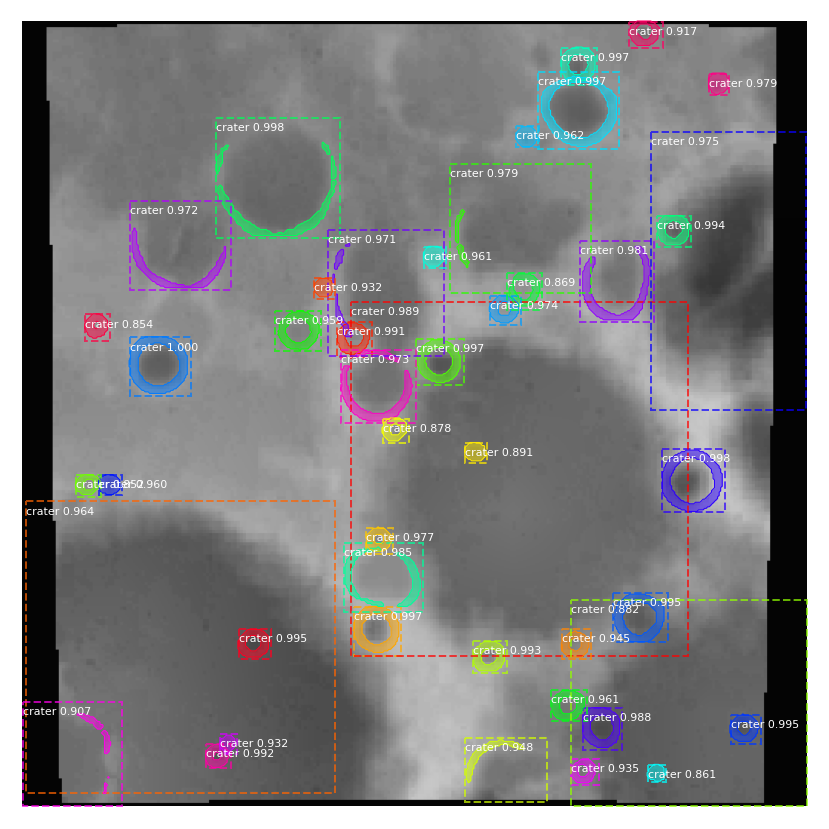

In [70]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)


print(f"Inferencing image n.{image_id}")
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, augmentation=None)

original_image = original_image*255
original_image = original_image.astype('uint8')

results = model.detect([original_image], verbose=0)

r = results[0]

a = r['masks']
b = r['rois']
c = r['class_ids']
d = r['scores']
print("\n\n\n")

visualize.display_instances(original_image, b, a, c, 
                            dataset_test.class_names, d, ax=get_ax())

N. of predicted craters:46


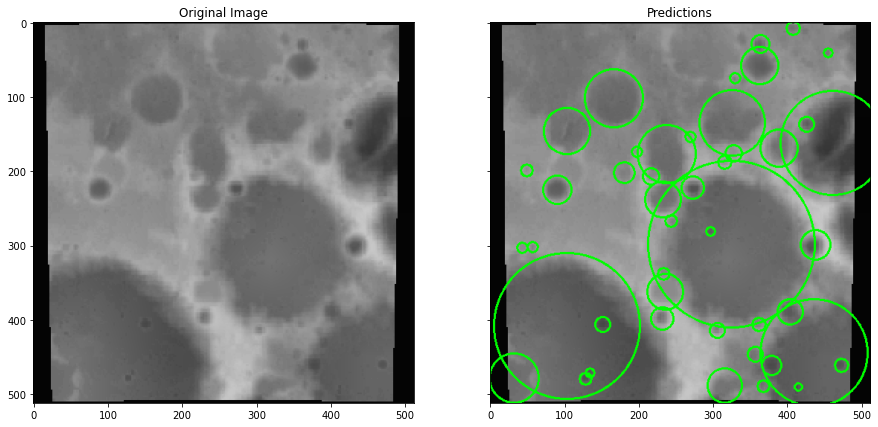

In [71]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(original_image)
ax1.set_title('Original Image')
img_predicted = inspect_results(original_image, b, color="green")
ax2.imshow(img_predicted)
ax2.set_title('Predictions')
print(f"N. of predicted craters:{b.shape[0]}")
plt.show()



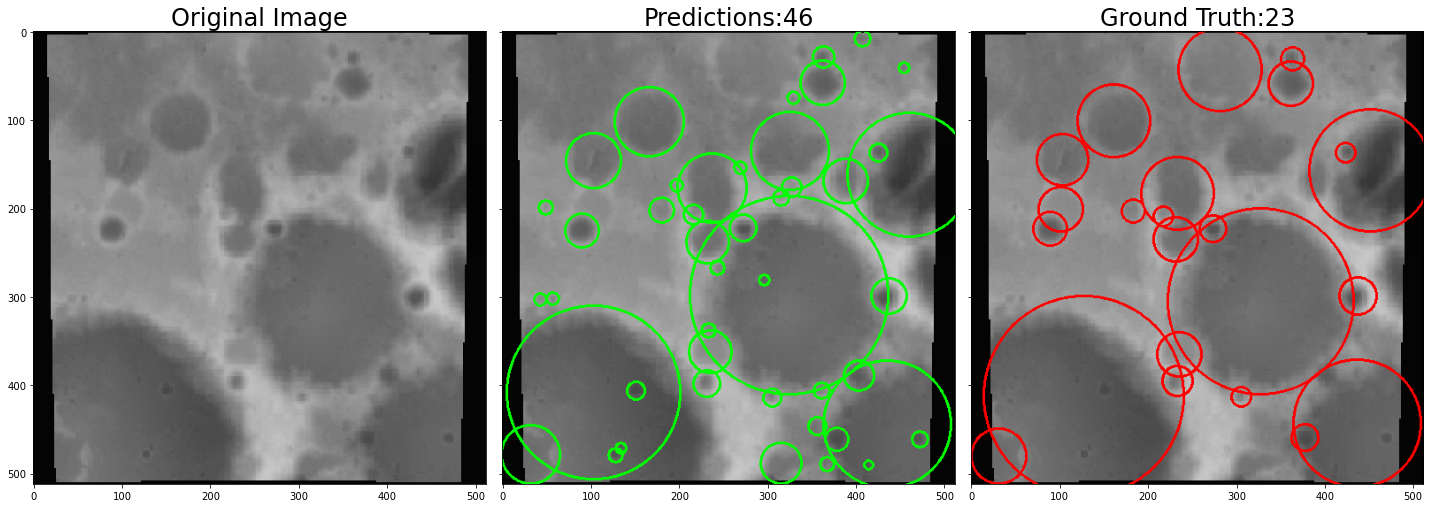

In [72]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,20))
ax1.grid(False)
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=24)


img_predicted = inspect_results(original_image, b, color="green")
ax2.grid(False)
ax2.imshow(img_predicted)
ax2.set_title(f'Predictions:{b.shape[0]}', fontsize=24)


img_truth = inspect_results(original_image, gt_bbox, color="red" )
ax3.grid(False)
ax3.imshow(img_truth)
ax3.set_title(f'Ground Truth:{gt_bbox.shape[0]}', fontsize=24)

plt.tight_layout()
plt.savefig('myfigure_300.png', dpi=300)
plt.show()


# Precision Recall

In [51]:
num_of_test = 1
P_ARRAY,R_ARRAY,F1_ARRAY,mAP_ARRAY = runinference(num_of_test)



print(f"PRECISION    Mean: {np.mean(P_ARRAY)}, STD: {np.std(P_ARRAY)}",end="\n")
print(f"RECALL       Mean: {np.mean(R_ARRAY)}, STD: {np.std(R_ARRAY)}",end="\n")
print(f"F1           Mean: {np.mean(F1_ARRAY)}, STD: {np.std(F1_ARRAY)}",end="\n")
print(f"mAP          Mean: {np.mean(mAP_ARRAY)}, STD: {np.std(mAP_ARRAY)}",end="\n")

PRECISION    Mean: nan, STD: nan
RECALL       Mean: 0.5, STD: 0.0
F1           Mean: nan, STD: nan
mAP          Mean: nan, STD: nan


In [ ]:
# Creates two subplots and unpacks the output array immediately

ax = plt.hist(P_ARRAY, bins=10)
plt.xlabel("Precision")
plt.savefig('Precision_300dpi.png', dpi=300)
plt.show()

plt.hist(R_ARRAY, bins=10)
plt.xlabel("Recall")
plt.savefig('Recall_300dpi.png', dpi=300)
plt.show()

plt.hist(F1_ARRAY, bins=10)
plt.xlabel("F1")
plt.savefig('F1_300dpi.png', dpi=300)
plt.show()

plt.hist(mAP_ARRAY, bins=10)
plt.xlabel("mAP")
plt.savefig('mAP_300dpi.png', dpi=300)
plt.show()




# Save File

In [ ]:
!mkdir info
%cd /home/sirbastiano/Documenti/notebook/info

filename="Mod1b.txt"
with open(filename,"w") as f:
  f.write(f"PRECISION    Mean: {np.mean(P_ARRAY)}, STD: {np.std(P_ARRAY)}\n"+ \
         f"RECALL       Mean: {np.mean(R_ARRAY)}, STD: {np.std(R_ARRAY)}\n" + \
         f"F1           Mean: {np.mean(F1_ARRAY)}, STD: {np.std(F1_ARRAY)}\n" + \
         f"mAP          Mean: {np.mean(mAP_ARRAY)}, STD: {np.std(mAP_ARRAY)}\n"        
         ) 


conf = str(config.to_dict())
conf_split = conf.split(",")
f = open("cf1b.txt","w") 

for line in conf_split:
    f.write(line+"\n")

f.close

# Precision Recall Plot

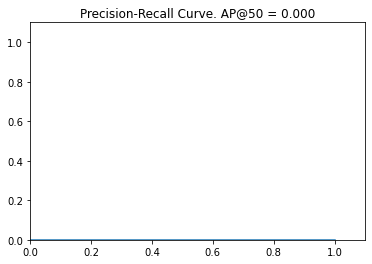

In [31]:
image_ids = np.random.choice(dataset_val.image_ids, 2)   
APs = []
for image_id in image_ids:
# Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config,
                           image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
# Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
visualize.plot_precision_recall(AP, precisions, recalls)

In [30]:
precisions

array([0., 0., 0.])

# Avg New Craters Detected

In [ ]:
DIFF = []
for i in range(10):
    image_id = random.choice(dataset_val.image_ids)
    #image_id = i

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, augmentation=None)

    results = model.detect([original_image], verbose=0)

    r = results[0]

    a = r['masks']
    b = r['rois']
    c = r['class_ids']
    d = r['scores']

    diff = diff_bb(gt_bbox, b)
    print(f"Percentage of difference is: {diff}")
    if diff !=None:
        if np.isfinite(diff):
            DIFF.append(diff)


media_nc = np.mean(DIFF).astype(int)
media_nc = media_nc*100
#media_nc = media_nc.astype(int)
print(f"La media di crateri trovati è il {media_nc:.2f}% rispetto quelli catalogati")




# Visualization ToolBox

In [ ]:
image = dataset_test.load_image(0)
image = image/255
plt.imshow(image)

In [ ]:
visual = []  
image = dataset_test.load_image(0)
mask = dataset_test.load_mask(0)

visual.append(image)
mask_ids = np.random.choice(mask[0].shape[-1],4)
for i in mask_ids: visual.append(mask[0][:,:,i])

image = dataset_test.load_image(1)
mask = dataset_test.load_mask(1)

visual.append(image)
mask_ids = np.random.choice(mask[0].shape[-1],4)
for i in mask_ids: visual.append(mask[0][:,:,i])

image = dataset_test.load_image(2)
mask = dataset_test.load_mask(2)

visual.append(image)
mask_ids = np.random.choice(mask[0].shape[-1],4)
for i in mask_ids: visual.append(mask[0][:,:,i])
    
image = dataset_test.load_image(3)
mask = dataset_test.load_mask(3)

visual.append(image)
mask_ids = np.random.choice(mask[0].shape[-1],4)
for i in mask_ids: visual.append(mask[0][:,:,i])


visualize.display_images(visual, titles=None, cols=5, cmap=None, norm=None,
                   interpolation=None)



In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


# Load and draw random image
image_id = np.random.choice(dataset_test.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_test, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


# Data Generator

In [ ]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})


for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)

